# Variational Autoencoder

In [ ]:
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers import Input, Dense, Lambda
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt 

In [ ]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

# First, here's our encoder network, mapping inputs to our latent distribution parameters:

inputs = keras.Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [ ]:
# We can use these parameters to sample new similar points from the latent space:

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
# Code z de cada imagem é um vetor bi-dimensional.
# Saída do encoder são três vetores, cada um 2-dim. 
# O primeiro tem o vetor de médias de z 
# O segundo tem o log do desvio-padrão de cada coordenada do code z
# O terceiro é o code z propriamente dito  

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=10,
        batch_size=32,
        validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 163.7323 - val_loss: 162.4529
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 160.9769 - val_loss: 160.5098
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 159.2052 - val_loss: 158.9537
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 157.7308 - val_loss: 157.6833
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 156.4302 - val_loss: 156.6377
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 155.3218 - val_loss: 155.3212
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 154.4452 - val_loss: 154.5237
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 153.7376 - val_loss: 153.7034
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 153.1498 - val_loss: 153.2751
Epoch 10/10
1875/1875 [=======================

In [ ]:
x_test_encoded = encoder.predict(x_test)
print(len(x_test_encoded))
print(len(x_test_encoded[0]))
print(x_test_encoded[0].shape)
print(len(x_test_encoded[1]))
print(x_test_encoded[1].shape)
print(len(x_test_encoded[2]))
print(x_test_encoded[2].shape)

3
10000
(10000, 2)
10000
(10000, 2)
10000
(10000, 2)


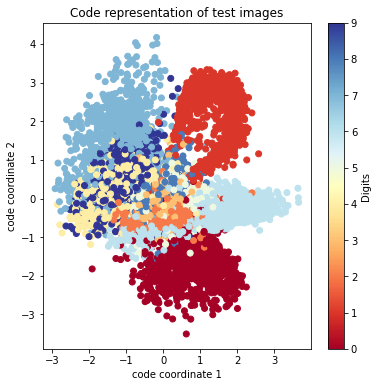

In [ ]:
plt.figure(figsize=(6, 6))
cm = plt.cm.get_cmap('RdYlBu')
z1 = x_test_encoded[2][:,0]
z2 = x_test_encoded[2][:,1]
plt.scatter(z1, z2, c=y_test, cmap=cm)
plt.title("Code representation of test images")
plt.xlabel("code coordinate 1")
plt.ylabel("code coordinate 2")
cbar = plt.colorbar()
cbar.set_label("Digits")
plt.show() 

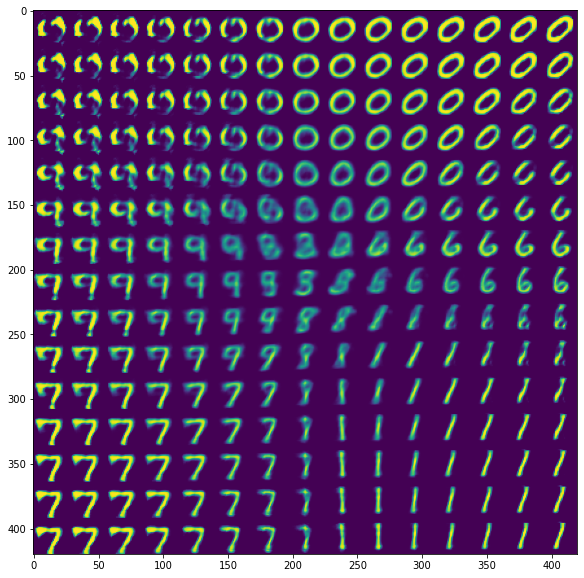

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-4, 4] standard deviations
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()